# Text Mining
# Lecture 4: Distributed Semantics

![img](https://www.tensorflow.org/versions/r0.10/images/linear-relationships.png)

In [1]:
from IPython.display import Image

## Recap & Issues

### Last Week

- Text can be tokenized, tokens can be counted.
- Documents can be represented as a vector with token count values.
- These vectors can be seen as a Vector Space model.
- Vectors can be weighted to be more informative.
- Through simple Vector Space calculations we can do some classification.

### In Practice

In [2]:
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

newsgroups = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

vectorizer = TfidfVectorizer()
vectors = np.asarray(vectorizer.fit_transform(newsgroups.data).todense())

In [3]:
query = ["USA space launch"]
qv = np.asarray(vectorizer.transform(query).todense())[0]
cos = {}

for i, dv in enumerate(vectors):
    cos[np.dot(qv, dv)] = i
    
scores = sorted(cos)[::-1]
scores[:5]

[0.3911516433798255,
 0.29651994760185252,
 0.25581635272977149,
 0.24790204776245364,
 0.21241493770390013]

In [4]:
newsgroups.target_names[newsgroups.target[cos[scores[0]]]]

'sci.space'

### In Practice II

In [5]:
query = ["blue screen of death"]
qv = np.asarray(vectorizer.transform(query).todense())[0]
cos = {}

for i, dv in enumerate(vectors):
    cos[np.dot(qv, dv)] = i
    
scores = sorted(cos)[::-1]

newsgroups.target_names[newsgroups.target[cos[scores[0]]]]

'comp.windows.x'

In [6]:
query = ["John kicked the ball"]
qv = np.asarray(vectorizer.transform(query).todense())[0]
cos = {}

for i, dv in enumerate(vectors):
    cos[np.dot(qv, dv)] = i
    
scores = sorted(cos)[::-1]

newsgroups.target_names[newsgroups.target[cos[scores[0]]]]

'sci.crypt'

### Left-over Issues

- TF\*IDF works pretty well, but has nothing to do with language other than occurence.
- Does not take into account order, context, semantics, nor any properties of the words.
- Information properties of both parts tf (Luhn, 1957), and df (Jones, 1972) pretty dated, and lack strong theoretical grounding.
- Need a lot of preprocessing to fix noisy features (e.g. misspellings).


### Fix 1: Change the Input

$n$-grams to the rescue!

- Up until now: word frequencies and bag-of-words.
- What if we use more words as features? - `"the cat", "cat jumped" "jumped on" "on the" "the table"`.
- Do the occurences of these pairs model language well?

### Language Modelling

Very easy approach: Markov Models

In [7]:
s = "I am Sam. Sam I am. I do not like green eggs and ham."
tokens = s.split()
bigrams = list(zip(*[tokens[i:] for i in range(2)]))
print(bigrams)

[('I', 'am'), ('am', 'Sam.'), ('Sam.', 'Sam'), ('Sam', 'I'), ('I', 'am.'), ('am.', 'I'), ('I', 'do'), ('do', 'not'), ('not', 'like'), ('like', 'green'), ('green', 'eggs'), ('eggs', 'and'), ('and', 'ham.')]


![img2](https://sookocheff.com/img/nlp/ngram-modeling-with-markov-chains/transitions-from-I.png)

![img3](https://sookocheff.com/img/nlp/ngram-modeling-with-markov-chains/following-transitions-from-I.png)

In [8]:
import random


class MarkovChain:

    def __init__(self):
        self.memory = {}

    def _learn_key(self, key, value):
        if key not in self.memory:
            self.memory[key] = []

        self.memory[key].append(value)

    def learn(self, text):
        tokens = text.split(" ")
        bigrams = zip(*[tokens[i:] for i in range(2)])
        for bigram in bigrams:
            self._learn_key(bigram[0], bigram[1])

    def _next(self, current_state):
        next_possible = self.memory.get(current_state)

        if not next_possible:
            next_possible = self.memory.keys()

        return random.sample(next_possible, 1)[0]

    def babble(self, amount, state=''):
        if not amount:
            return state

        next_word = self._next(state)
        return state + ' ' + self.babble(amount - 1, next_word)

### Language Modelling II

In [9]:
from glob import glob
import re

files = glob('../Week 1 - Introduction/data/*.txt')
chain = MarkovChain()

for f in files:
    text = open(f).read().lower()
    chain.learn(re.sub('[^\w \-]', '', text))

In [10]:
chain.babble(50)

'  non-relevant documents to the aspects of lines non-polyhedral and the technolangueeasy project displayedone such that john zisserman andrew zisserman 2003 computer automated image processing and related tasksother tasks classifier that observations into three levels and behavior of 100 14441451 doi101109jproc20122189916   jump up     '

```'  this measure of the 1940s alan turings proposal to is strongly np-hard and retrieval and job offers related to the ability to take one or other terms is an algorithm basic techniques should artificial neuronsthe field of artificial beings head and applications include swarm intelligence ai effecthigh-profile examples of'```

### Further Expansion

- Can use any $n$-gram; trigrams, tetragram, etc.
    - The longer the gram, the more improbable it will be in test data.
- Use character grams to capture spelling variations.
    - Very effective in stylometry.

However:
- $n$-grams have proven very effective in a lot of text mining applications (and are hard to beat baselines)
- cannot capture long dependencies, or intuitive relations
- results in very sparse, long vectors

## Introduction to Distributed Semantics

### Vector Semantics

`"oculist and eye-doctor... occur in almost the same environments", "If A and B have almost identical environments... we say that they are synonyms."` - Harris, 1954


`"You shall know a word by the company it keeps!"` - Firth, 1957

### Vector Semantics II

- The meaning of a word is regulated by those around it:
    * A bottle of *tesgüino* is on the table.
    * Everybody likes *tesgüino*.
    * *Tesgüino* makes you drunk.
    * We make *tesgüino* out of corn.
- More complex:
    - occurs after `bottle`
    - occurs before `drunk`
    - direct object of `likes`

### From Document Vectors to Word Vectors

In [11]:
v1 = vectors[:,vectorizer.vocabulary_['computer']]
v2 = vectors[:,vectorizer.vocabulary_['pc']]

print(np.intersect1d(v1.nonzero(), v2.nonzero()))

v1 = vectors[:,vectorizer.vocabulary_['apples']]
v2 = vectors[:,vectorizer.vocabulary_['pc']]
print(np.intersect1d(v1.nonzero(), v2.nonzero()))

[ 282  461  565  719  740  884 1030 1086 1146 1152 1155 1169 1276 1333 1626
 1715 1800 1857 1999 2082 2145 2160 2368 2384 2711 2828 3090 3146 3393 3467
 3879 3997 4198 4232 4428 4533 4591 4893 4957 5044 5271 5328 5417 5430 5449
 6136 6137 6433 6651 6688 6974 7030 7153 7273 7328 7448]
[ 740 1391]


### Word * Context Matrices

- `word * word` matrix (where columns are contexts).
- `vocab * vocab` length.
- Frequencies are actually co-occurence counts in some window (4 for example).
- Each axis is a word, each vector represents a word that has stronger co-occurence if closer to axis.
- We distinguish two types of co-occurence:
    - First-order: typically near, e.g. `wrote`, `book`.
    - Second-order: same neighbours, e.g. `said`, `remarked`.

### Frequencies?

|             | computer | data | pinch | result | sugar |
| ----------- | -------- | ---- | ----- | ------ | ----- |
| apricot     | 0        | 0    | 1     | 0      | 1     |
| pineapple   | 0        | 0    | 1     | 0      | 1     |
| digital     | 2        | 1    | 0     | 1      | 0     |
| information | 1        | 6    | 0     | 4      | 0     |

- Again turn out not to be the best measures of association.
- Very frequent words like `a` and `the` are not gonna provide good discrimination.

### (Positive) Pointwise Mutual Information (PPMI)

$PPMI(w,c) = \max(\log_2 \frac{P(w,c)}{P(w)P(c)}, 0)$

where $w =$ word and $c =$ context, and if PPMI < 0, PPMI = 0.

Numerator: how many times do they co-occur. Denominator: expect co-occurence when they occur independently (therefore higher value is less 'by chance'). So (19 is sum of words):

$P(w=information,c=data) = \frac{6}{19}$

$P(w=information) = \frac{11}{19}$

$P(c=data) = \frac{7}{19}$

$PMI(information,data) = \log_2(.316/(.368 ∗ .579)) = .568$

### PPMI Result


|             | computer | data | pinch | result | sugar |
| ----------- | -------- | ---- | ----- | ------ | ----- |
| apricot     | 0        | 0    | 2.25  | 0      | 2.25  |
| pineapple   | 0        | 0    | 2.25  | 0      | 2.25  |
| digital     | 1.66     | 0    | 0     | 0      | 0     |
| information | 0        | 0.57 | 0     | 0.47   | 0     |

### Dense Representations

- `word * context` matrices are **long** (many words) and **sparse** (lot of zeroes).
- Alternative: make them **short** (fewer words) and **dense** (few zeroes).
- Good for machine learning purposes (faster, less chance of overfitting)!

- 'Classic' (linalg) ways of doing this through (P)LSI (Deerwester et al.), or LDA (Blei et al.). Workings out of scope for course.

## Semantics through Prediction: `word2vec`

### Popularity

- Many papers surrounding `word embeddings` in 2016.
- `word2vec` simply implemented in packages like `gensim`.
- Very fast, and memory efficient even for huge corpora.
- Models are easily stored and loaded.

### Neural Word Embeddings

![img2](http://ufldl.stanford.edu/tutorial/images/Network3322.png)

### Embeddings Through Predicition

- Functionalility based on word prediction; so for example ``"the __ sat on the mat"``.
- However, we are not interested in predicition, but semantic similarity.

### (Simplified) Architecture

- Two methods:
    - Skip-gram: predicts some neighboring word from a starting word, so for example:
        - `"today my cat ate fish"`: predict `my` given `cat`, predict `today` given `cat`, same for right side.
    - Continous Bag of Words (CBOW): Mirror image of skip-gram; predict word given context words, so:
        - `"today my cat ate fish"`: predict `cat` given `my`, predict `cat` given `today`, same for right side.

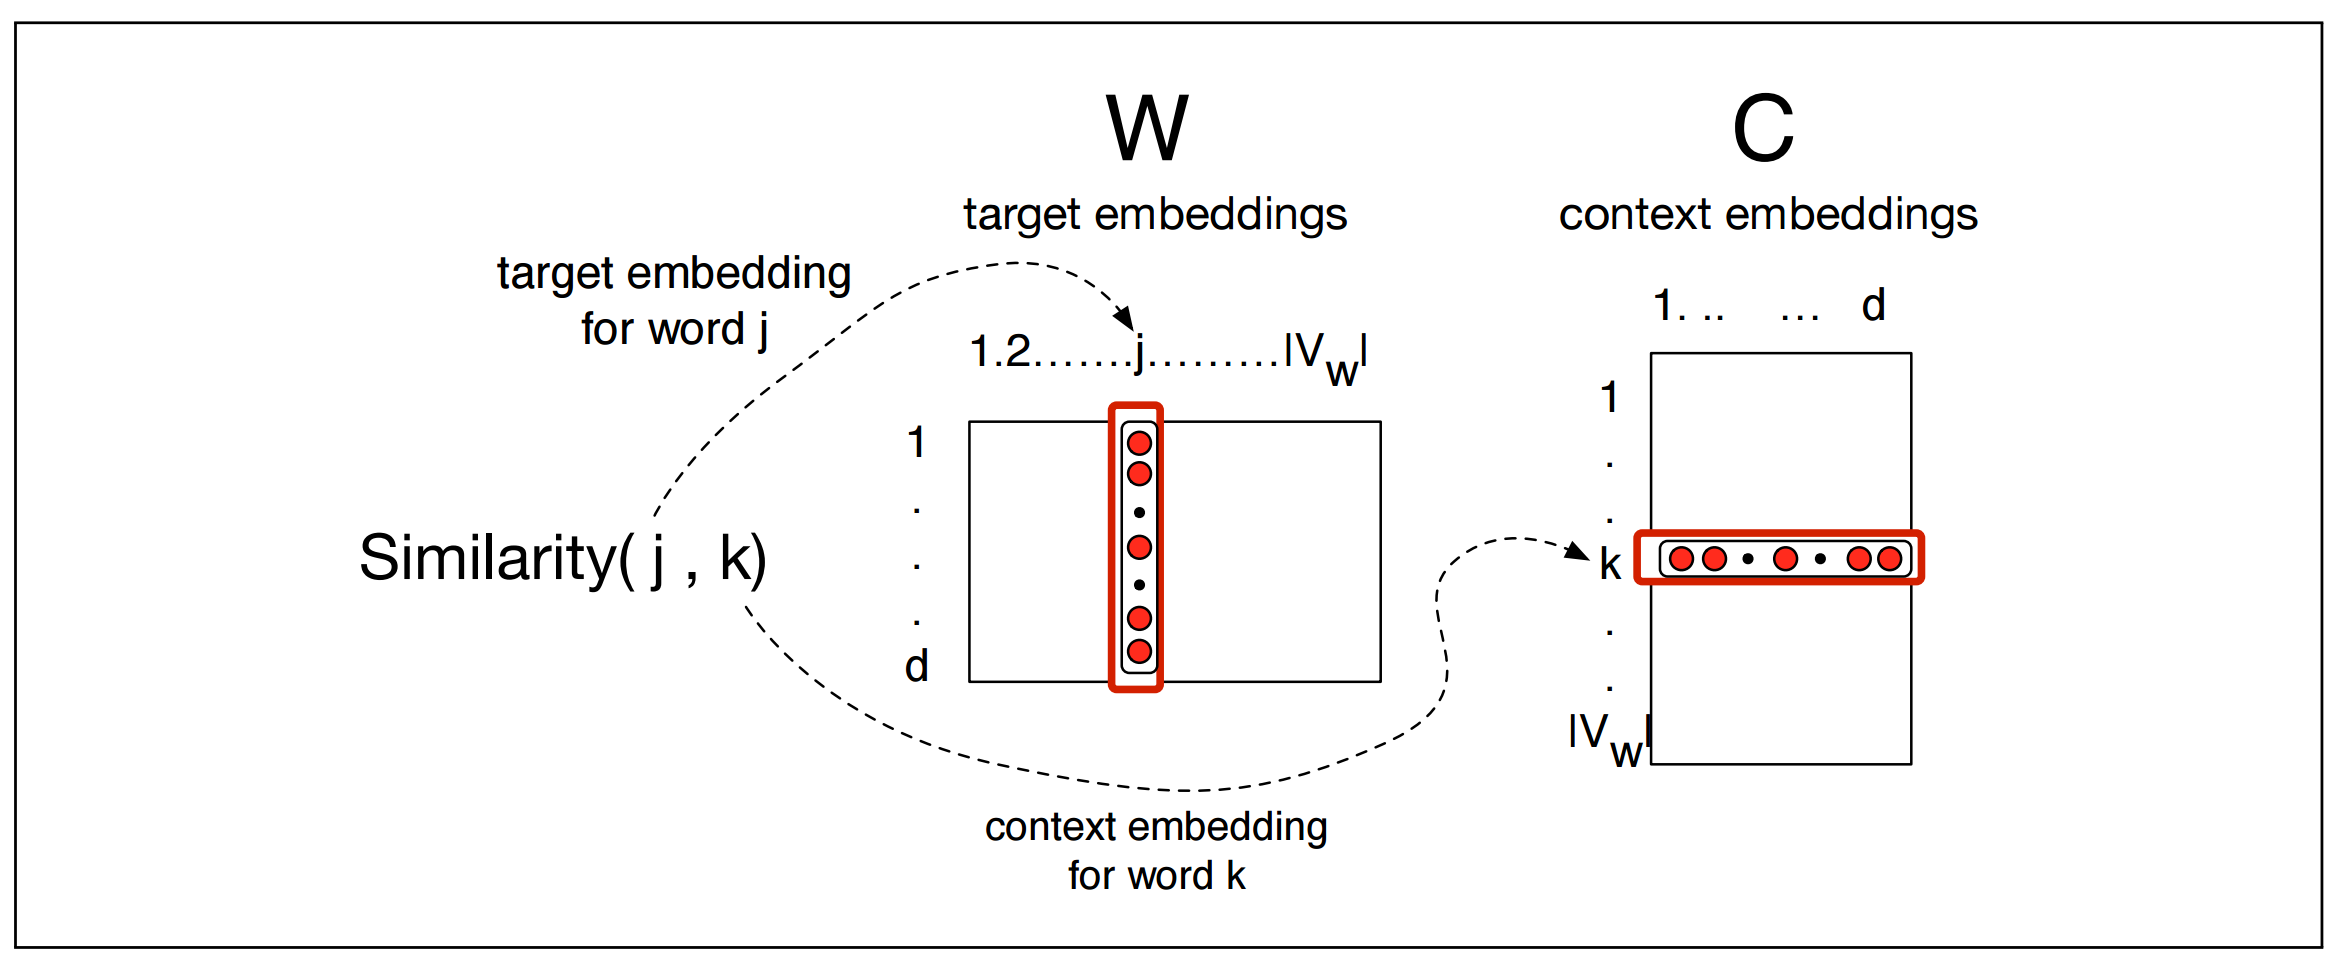

In [12]:
Image(filename='./img/w2v_skip.png')

### (Simplified) Architecture II

- Goal: make the embeddings for a word more like the embeddings of its neighbors and less like the embeddings of other words. 
- Randomly initialize target vector.
- Compute dot product given context vector and target vector (transforms dot product to probability with softmax function).
- Optimal when word vector is closest to words that it co-occurs with.

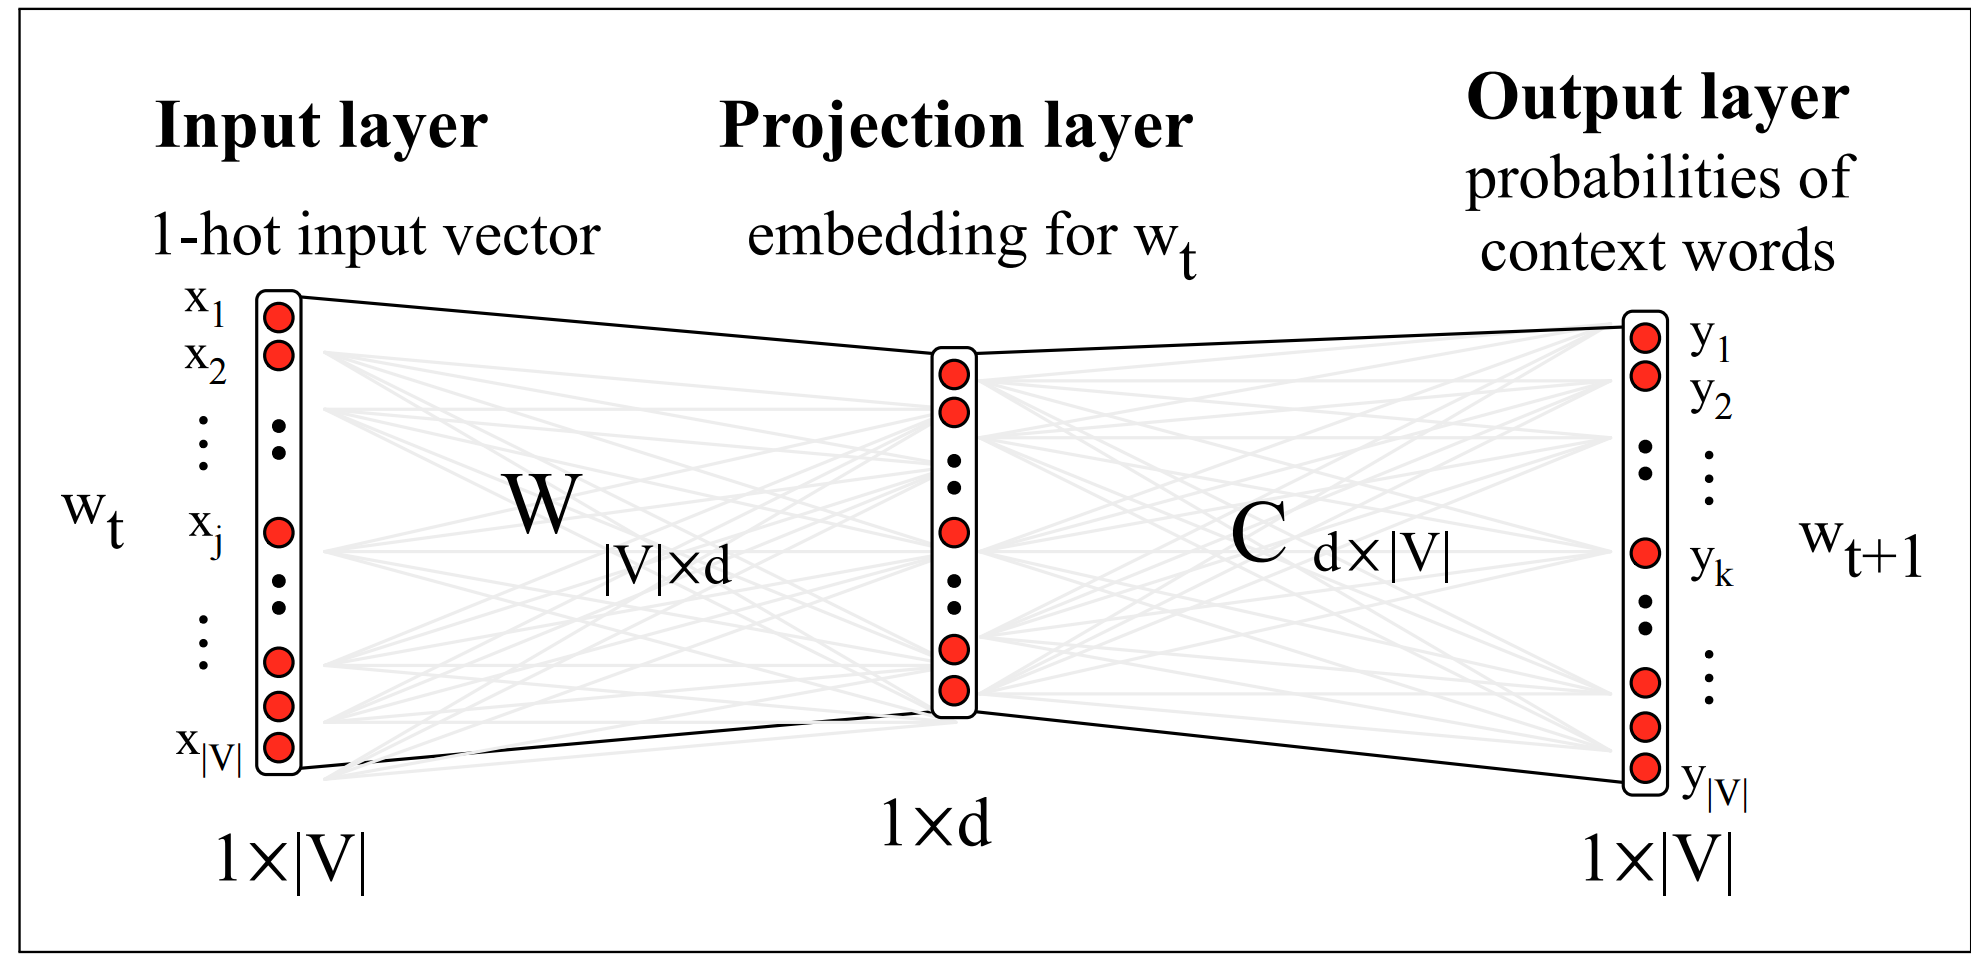

In [13]:
Image(filename='./img/w2v_net.png')

### Vector Computation

- `vector('king') - vector('man') + vector('woman') = vector('queen')`
- `vector('Paris') - vector('France') + vector('Italy') = vector('Rome')`


- Evaluation: $A$ is to $B$ as $C$ is to $D$.
- see: https://github.com/arfon/word2vec/blob/master/questions-words.txt.

### Gensim

In [14]:
%%time
from gensim.models import Word2Vec
model = Word2Vec([sentence.split() for document in newsgroups.data
                  for sentence in document.split('. ')],
                 size=100, window=5, min_count=5, workers=4)

CPU times: user 18.6 s, sys: 124 ms, total: 18.7 s
Wall time: 7.5 s


In [15]:
model.similarity('apple', 'microsoft')

0.67590536490729014

In [16]:
model.similarity('Bob', 'Alice')

0.93439081176750838

In [17]:
model.most_similar(positive=['woman', 'king'], negative=['man'])

[('corruption', 0.945447564125061),
 ('advocating', 0.9397861957550049),
 ('out"', 0.9364532828330994),
 ('sin.', 0.9349919557571411),
 ('applicable', 0.9346062541007996),
 ('Bible.', 0.9343096017837524),
 ('context,', 0.9331258535385132),
 ('Religion', 0.9330323934555054),
 ('Regarding', 0.9325460195541382),
 ('ONLY', 0.9312723278999329)]

### Result

See simplified T-SNE version: http://www.cs.toronto.edu/~hinton/turian.png.

### Usefulness

- Fast, lean, easy to store and load.
- Input to other models.
- Not necessarily better than classic DSMs (although hype would suggest otherwise).

### Practical Example: Embeddings as a Linguistic Resource

Tulkens, Emmery, Daelemans (2016); state-of-the-art word embeddings for Dutch :) 

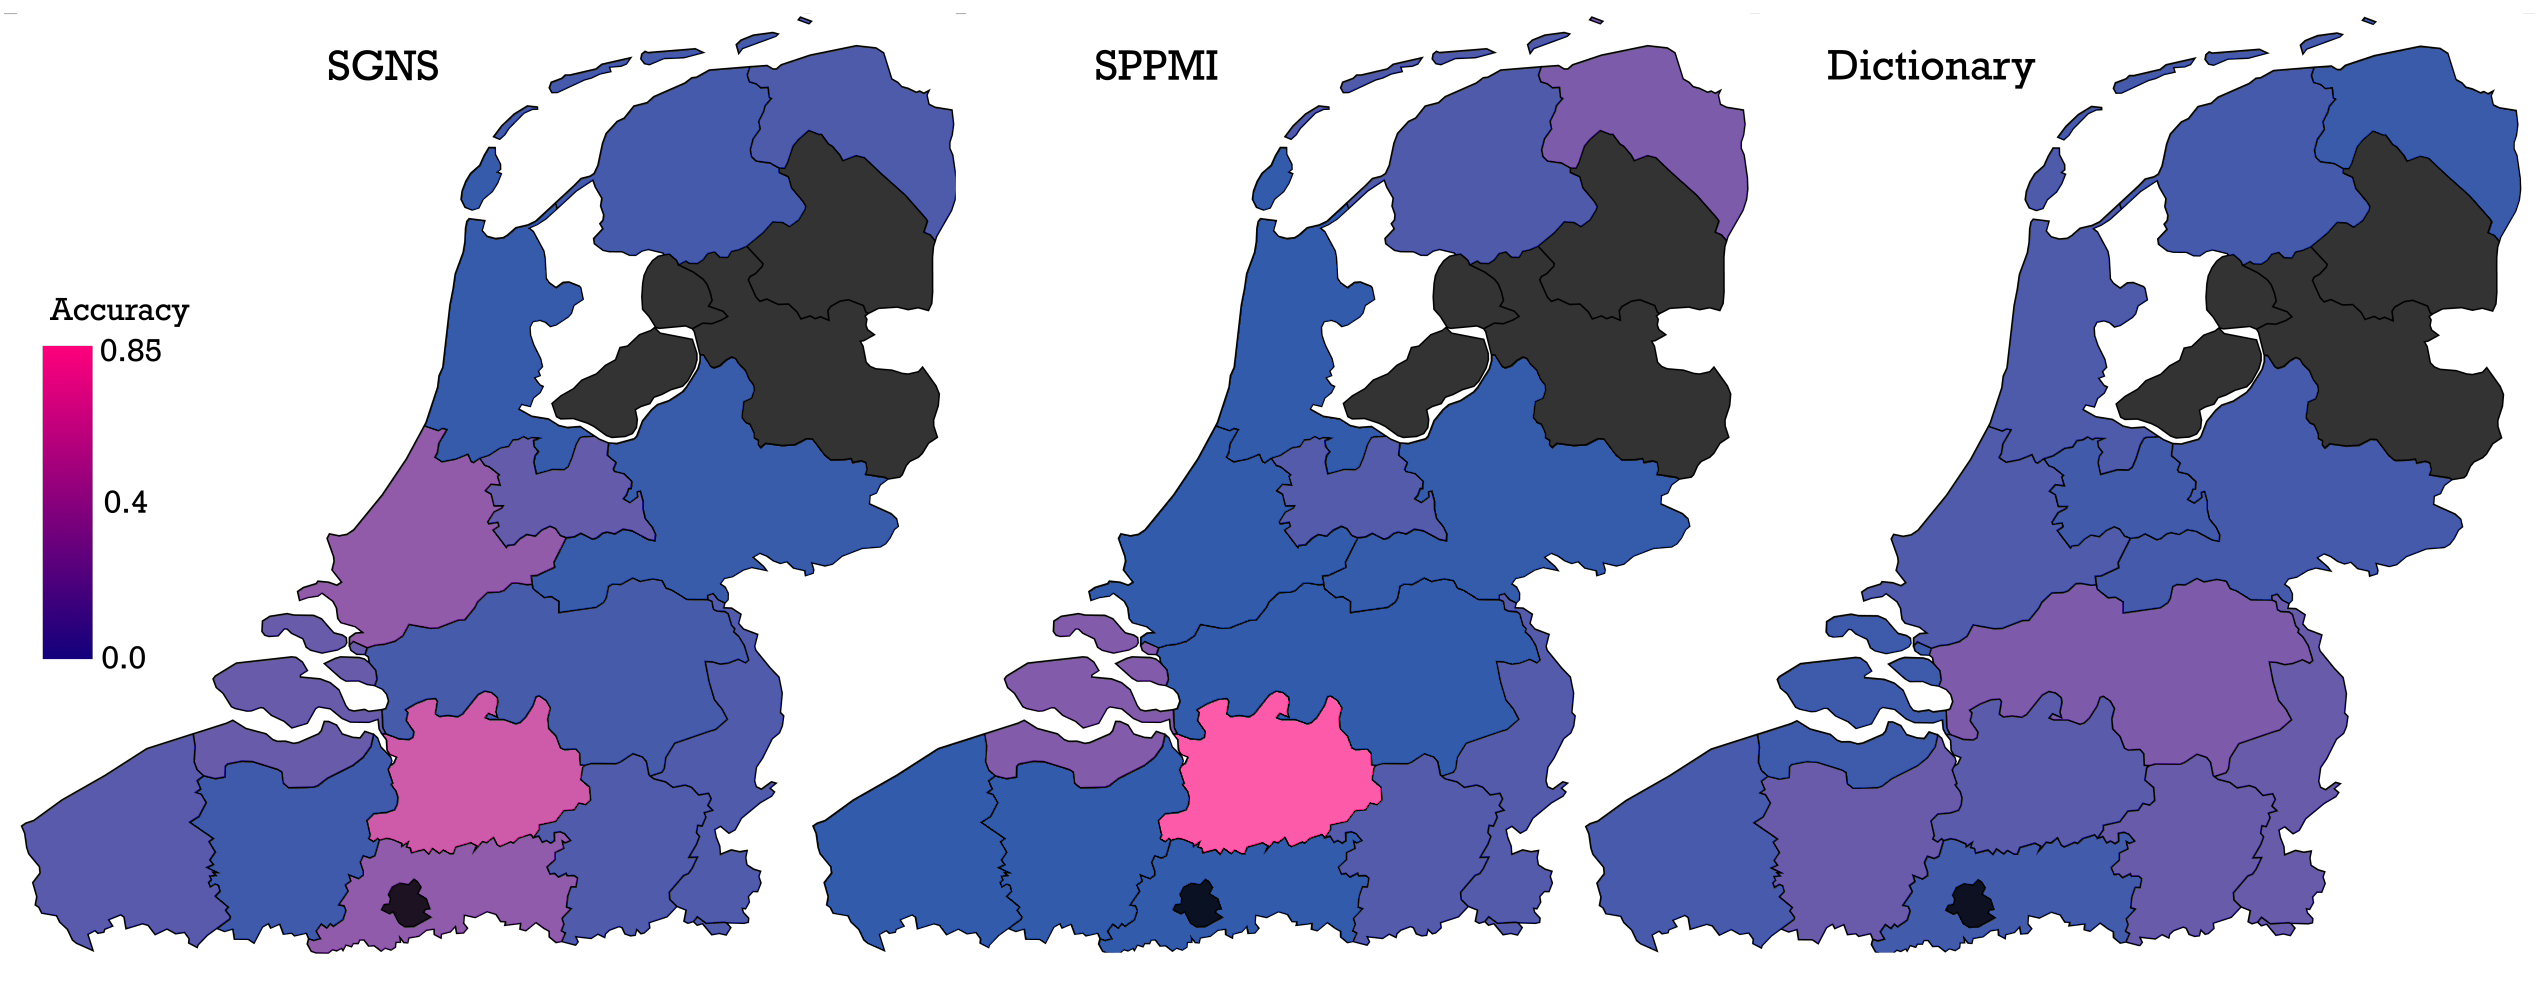

In [18]:
Image(filename='./img/dialect.png')

### Practical Example II: Word Mover's Distance for Ranking

![img3](https://github.com/mkusner/wmd/blob/master/fig1.png?raw=true)